# Data exploration

### Utils

In [1]:
# import utils
import cv2
import os 
import sys
import matplotlib.pyplot as plt 
import albumentations as A
from albumentations.pytorch import ToTensorV2

# import functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
  data = fetch_version_info()


ModuleNotFoundError: No module named 'torch'

### Paths

In [2]:
images_path = '../data/processed/images'
labels_path = '../data/processed/labels'

## Data correction

In [3]:
# Check if every image has a label
check_images_labels(images_path=images_path, labels_path=labels_path)

# Number of images
n_images = get_num_images(images_path=images_path)
print(f"Number of images: {n_images}")

All images have corresponding labels
Number of images: 1480


## Loading images

In [4]:
def draw_bounding_box(image_path, bounding_boxes):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_height, img_width = image.shape[:2]

    # Define the colors
    colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0),
        4: (255, 0, 255),
        5: (0, 255, 255),
    }

    for bbox in bounding_boxes:
        class_id, x_center, y_center, width, height = bbox

        # Convert the coordinates to absolute values
        x_center, y_center = int(x_center * img_width), int(y_center * img_height)
        width, height = int(width * img_width), int(height * img_height)

        # Calculate the top-left and bottom-right corner of the bounding box
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Class color
        color = colors[class_id]

        # Draw the bounding box
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        # Add the class name
        cv2.putText(
            image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

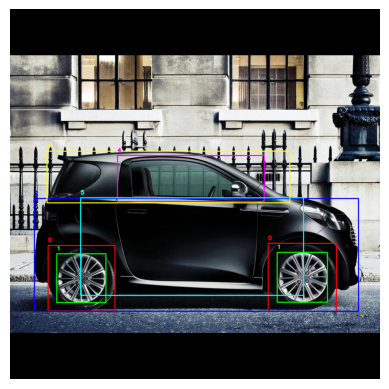

In [5]:
image_path = '../data/processed/images/A_Ast_01.jpg'
image_label_path = '../data/processed/labels/A_Ast_01.txt'

bounding_boxes = []
with open(image_label_path, 'r') as file:
    for line in file:
        class_id, x_center, y_center, width, height = line.strip().split()
        bounding_boxes.append([int(class_id), float(x_center), float(y_center), float(width), float(height)])

draw_bounding_box(image_path, bounding_boxes)


# Convert LabelME JSON labels into COCO formats

In [ ]:
labelme_dir = "../data/with_labels/json"
coco_labels_file = "../data/with_labels/labels/coco_annotations.json"
labelme_to_coco(labelme_dir, coco_labels_file)

COCO annotations saved to ../data/with_labels/labels/coco_annotations.json


## Visualization COCO Format

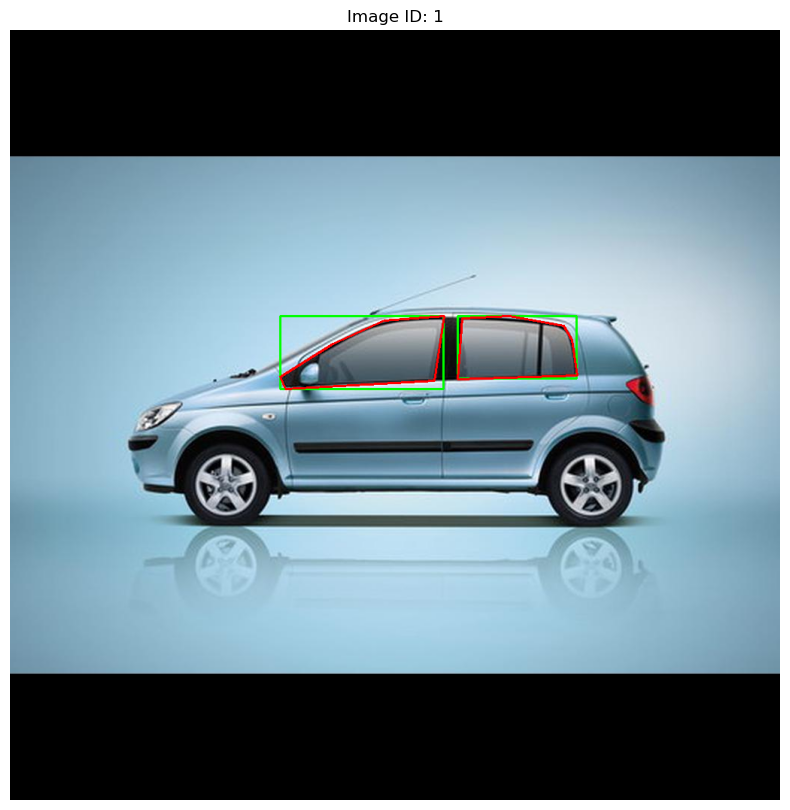

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_coco_annotations(coco_json, images_dir, num_samples=5):
    """
    Visualizes COCO annotations by overlaying bounding boxes and segmentation masks on images.
    
    Parameters:
        coco_json (str): Path to the COCO JSON file.
        images_dir (str): Directory containing the images.
        num_samples (int): Number of images to visualize.
    """
    # Load COCO JSON
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    # Map image IDs to image metadata
    image_dict = {img["id"]: img for img in coco_data["images"]}

    # Map annotations by image_id
    annotations_by_image = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Visualize a subset of images
    for img_id, img_data in list(image_dict.items())[:num_samples]:
        img_path = Path(images_dir) / img_data["file_name"]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

        # Overlay annotations
        if img_id in annotations_by_image:
            for ann in annotations_by_image[img_id]:
                # Draw bounding box
                bbox = ann["bbox"]
                x_min, y_min, width, height = map(int, bbox)
                x_max, y_max = x_min + width, y_min + height
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

                # Draw segmentation (if available)
                if "segmentation" in ann:
                    points = ann["segmentation"][0]
                    points = [(int(points[i]), int(points[i + 1])) for i in range(0, len(points), 2)]
                    for i in range(len(points)):
                        cv2.line(image, points[i], points[(i + 1) % len(points)], color=(255, 0, 0), thickness=2)

        # Display the image with annotations
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Image ID: {img_id}")
        plt.axis("off")
        plt.show()

# Example usage
images_dir = "../data/with_labels/images"        # Path to your image directory
visualize_coco_annotations(coco_labels_file, images_dir, num_samples=1)
